### Here we study the photometry noise based on the GAMA catalog

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import torch
import corner
import os

In [3]:
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.utils import flux2mag, mag2flux, sigma_flux2mag, sigma_mag2flux

In [104]:
gama_cat = Table.read('./reference_catalog/GAMA/DR3ApMatchPhotStellarMass.fits')
print(len(gama_cat))

filters = list('ugrizYJHK')
mags = np.vstack([gama_cat[col].data for col in [f'MAG_AUTO_{filt}' for filt in filters]]).T
mags_err = np.vstack([gama_cat[col].data for col in [f'MAGERR_AUTO_{filt}' for filt in filters]]).T
fluxes = np.vstack([gama_cat[col].data for col in [f'FLUX_AUTO_{filt}' for filt in filters]]).T
fluxes_err = np.vstack([gama_cat[col].data for col in [f'FLUXERR_AUTO_{filt}' for filt in filters]]).T

flag = np.all((mags != 99.0), axis=1) & np.all((mags != -9999.0), axis=1) & np.all((mags != -99.0), axis=1)
flag &= np.all(fluxes_err > 0, axis=1)
flag &= np.all(fluxes > 0, axis=1)
flag &= ((mags[:, 6] - mags[:, 8]) > 0.025) #& (mags[:, 2] < 19.65)
flag &= (mags[:, 0] < 90)# & (mags[:, 0] < 25)
flag &= (gama_cat['logmintsfh'] > 0) # exclude -99.0
# flag &= (mags_err[:, 0] < 0.6)
# flag &= #np.all(snrs[:, 0:1] >= 2, axis=1) # SNR cut
gama_cat = gama_cat[flag]
print(len(gama_cat))

120739
102644


In [105]:
filters = list('ugrizYJHK')
mags = np.vstack([gama_cat[col].data for col in [f'MAG_AUTO_{filt}' for filt in filters]]).T
mags_err = np.vstack([gama_cat[col].data for col in [f'MAGERR_AUTO_{filt}' for filt in filters]]).T

In [106]:
filters = list('ugrizYJHK')
fluxes = np.vstack([gama_cat[col].data for col in [f'FLUX_AUTO_{filt}' for filt in filters]]).T
fluxes_err = np.vstack([gama_cat[col].data for col in [f'FLUXERR_AUTO_{filt}' for filt in filters]]).T

zp = 30

In [107]:
logsnrs = np.log10(fluxes / fluxes_err)

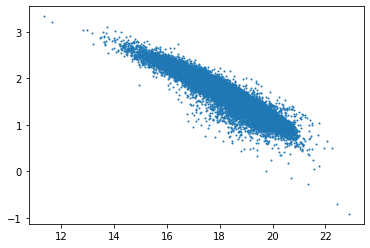

In [108]:
# plt.scatter(mags[:, 0], np.log10(fluxes[:, 0] / fluxes_err[:, 0]), s=1)
# plt.scatter(mags[:, 1], np.log10(fluxes[:, 1] / fluxes_err[:, 1]), s=1)
plt.scatter(mags[:, 2], logsnrs[:, 2], s=1)

# plt.xlim(-40, 100)
# plt.yscale('log')

In [109]:
z_mass_met = np.vstack([gama_cat['Z'], gama_cat['logmintsfh'], np.log10(gama_cat['metal']) - np.log10(0.0190)  - 0.8]).T

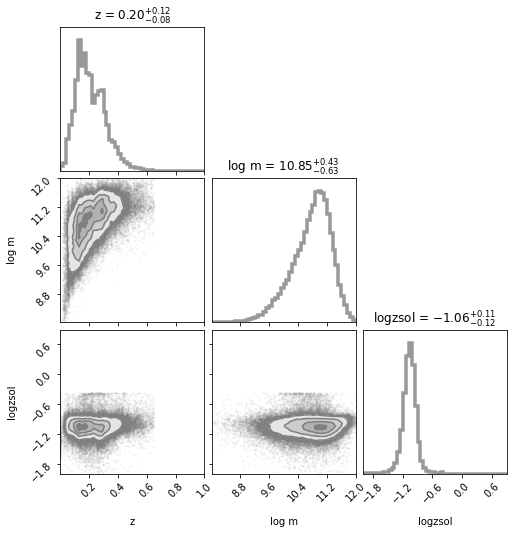

In [110]:
import corner
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=50,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.1, fill_contours=True,
                       range=[[0, 1], [8, 12], [-2, 0.9]], 
                       lw=1,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# figure = corner.corner(z_mass_met[flag], 
#                        fig=figure,
#                   labels=['z', 'log m', 'logzsol'], bins=50,
#                   color='dodgerblue',
#                        range=[[0, 1], [8, 12], [-2, 0.9]], 
#                   smooth=0.1, fill_contours=True,
#                   show_titles=True, title_kwargs={"fontsize": 12}, 
#                         hist_kwargs={'density': True}, plot_datapoints=True)

In [111]:
len(gama_cat)

102644

(7.0, 12.5)

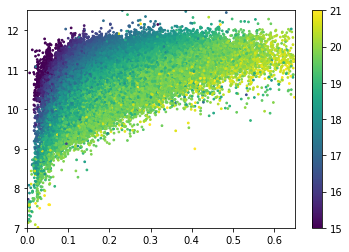

In [112]:
plt.scatter(gama_cat['Z'], gama_cat['logmintsfh'], c=gama_cat['MAG_AUTO_r'], 
            s=3, vmin=15, vmax=21)
plt.colorbar()

plt.xlim(0, 0.65)
plt.ylim(7, 12.5)

(8.0, 12.5)

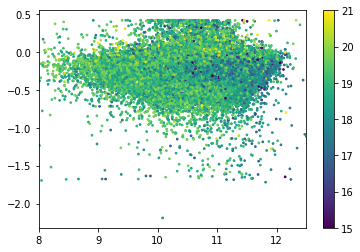

In [114]:
plt.scatter(gama_cat['logmintsfh'], np.log10(gama_cat['metal'] / 0.019), c=mags[:, 2],
            s=3, vmin=15, vmax=21)
plt.colorbar()

plt.xlim(8, 12.5)

In [119]:
np.sum(10**logsnrs[:, 0] < 3)

63470

In [122]:
np.save('./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch.npy', mags)
np.save('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy', z_mass_met)

---

### Noise model

`sigs` is defined as $\Delta m$

In [125]:
sigs = logsnrs

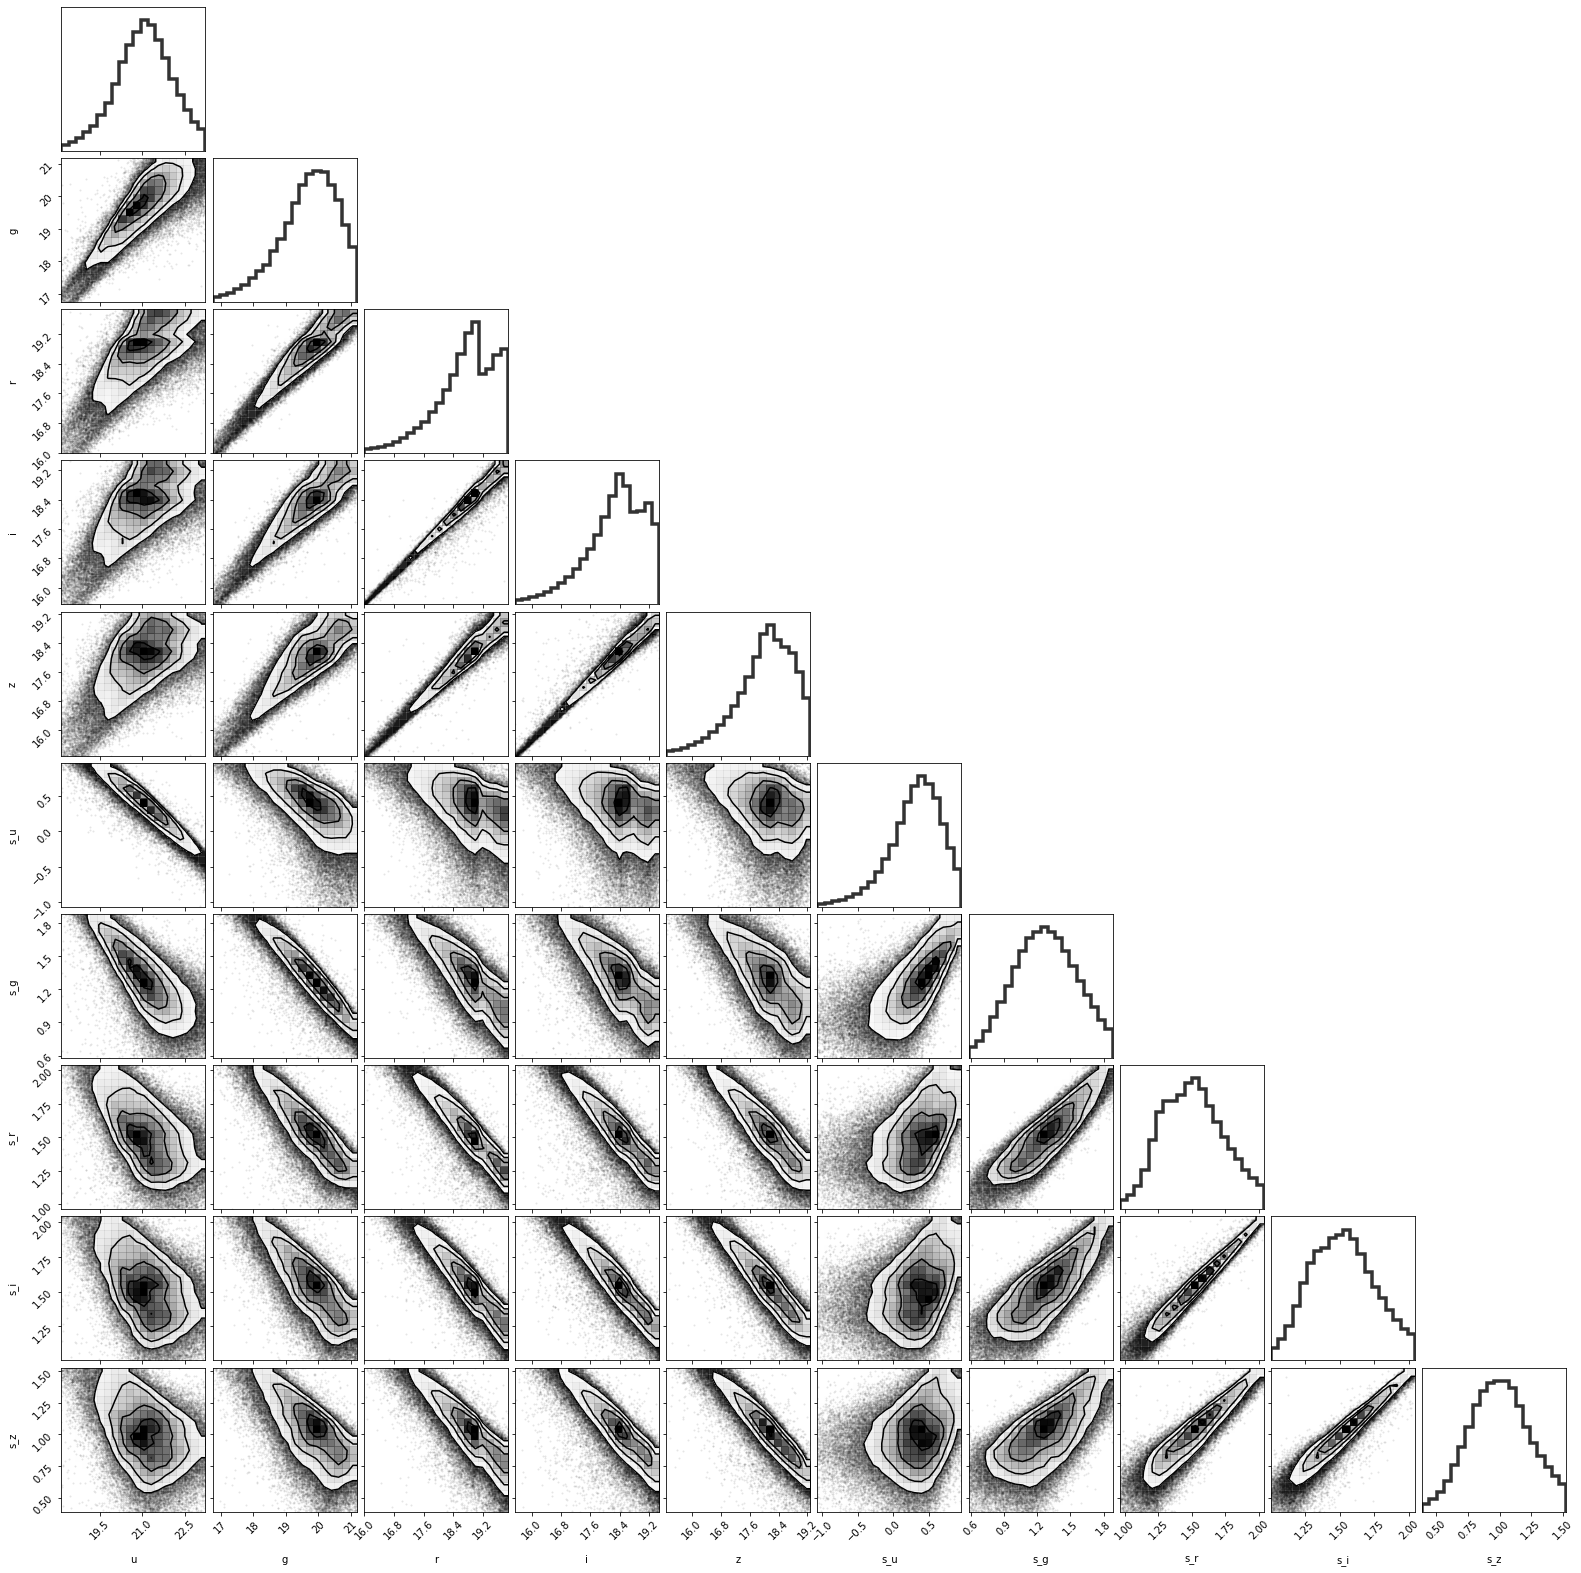

In [126]:
fig = corner.corner(np.concatenate([mags[:, :5], sigs[:, :5]], axis=1), 
                    range=np.nanquantile(
                     np.concatenate([mags[:, :5], sigs[:, :5]], axis=1), 
                     [0.01, 0.95], axis=0).T,
                    labels=list('ugriz') + [f's_{filt}' for filt in list('ugriz')]) 

In [127]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [128]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
def trimmed_median(x): 
    xlim = np.quantile(x, [0.0, 0.999]) #0.998
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.0, 0.999])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

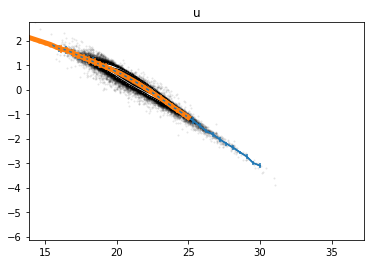

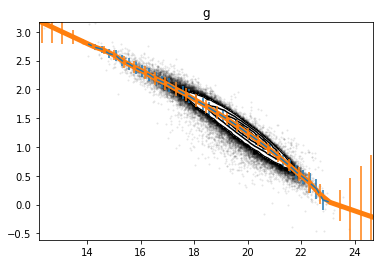

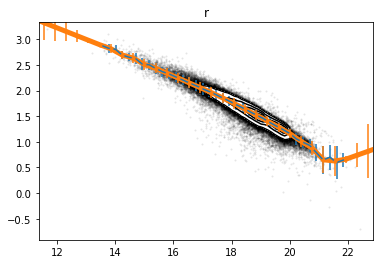

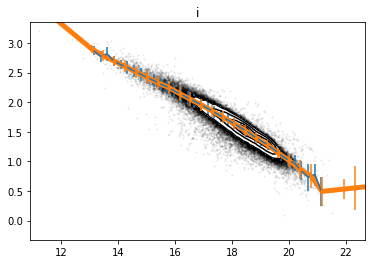

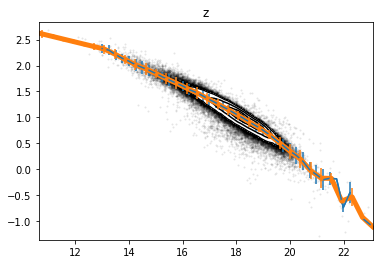

In [143]:
meds_sigs, stds_sigs = [], [] 

# for i in range(len(filters)): 
for i in range(5): #range(len(filters)): 
    clean = (np.isfinite(mags[:,i]))# & (sigs[:,i] < np.max([np.quantile(sigs[:,i], 0.99), 0.5])))

    med_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_median, 
                                              range=np.nanquantile(mags[clean,i], [0., 1]), bins=50)
    std_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_std, 
                                              range=np.nanquantile(mags[clean,i], [0., 1]), bins=50)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], 
                              fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], 
                              fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags[clean,i], sigs[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
#     sub.set_xlim(np.nanquantile(mags[clean,i], [0.01, 1.]))
#     sub.set_ylim(np.nanquantile(sigs[clean,i], [0.0, 0.995]))
    
    sub.set_title(filters[i])

In [144]:
np.save('./noise_model/gama_snr_model_mag_dr3_apmatch.npy', np.vstack([meds_sigs, stds_sigs]))

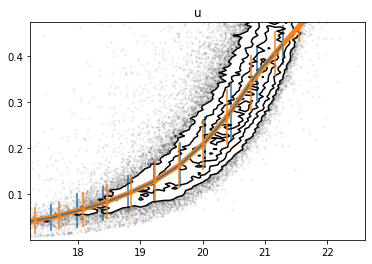

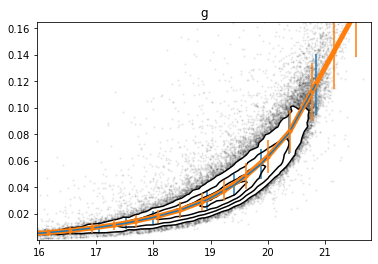

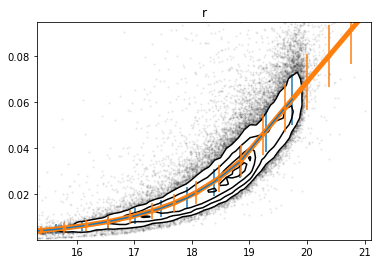

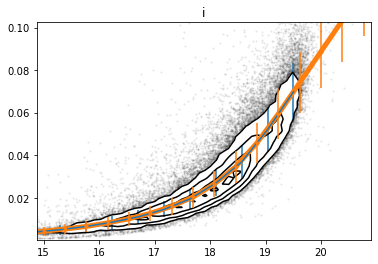

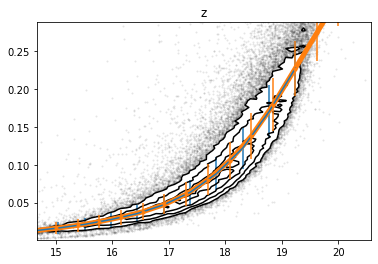

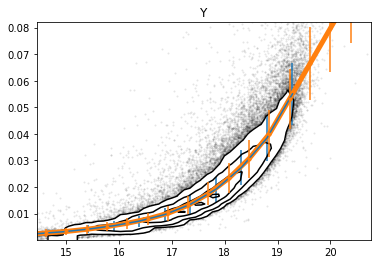

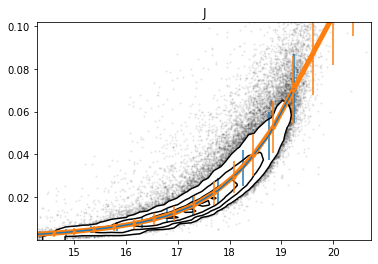

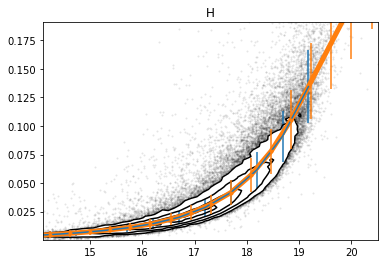

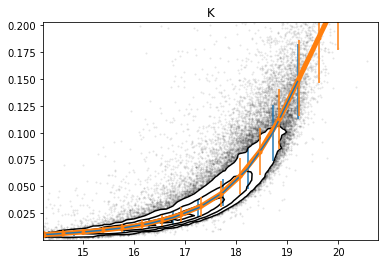

In [93]:
meds_sigs, stds_sigs = [], [] 

# for i in range(len(filters)): 
for i in range(len(filters)): 
    clean = (np.isfinite(mags[:,i]) & (sigs[:,i] < np.max([np.quantile(sigs[:,i], 0.9), 0.3])))

    med_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_median, 
                                              range=np.nanquantile(mags[clean,i], [0., 0.997]), bins=20)
    std_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_std, 
                                              range=np.nanquantile(mags[clean,i], [0., 0.995]), bins=20)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], 
                              fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], 
                              fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags[clean,i], sigs[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
    sub.set_xlim(np.nanquantile(mags[clean,i], [0.01, 1.]))
    sub.set_ylim(np.nanquantile(sigs[clean,i], [0.0, 0.995]))
    
    sub.set_title(filters[i])

In [94]:
np.save('./noise_model/gama_noise_model_mag_dr3_apmatch_snr2.npy', np.vstack([meds_sigs, stds_sigs]))